# Data Modeling with Logistic Regression model

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from category_encoders import WOEEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import PolynomialFeatures as Poly

from mlxtend.evaluate import feature_importance_permutation

from mlxtend.feature_extraction import PrincipalComponentAnalysis
from mlxtend.preprocessing import standardize

from mlxtend.feature_extraction import RBFKernelPCA as KPCA
from pyearth import Earth

from mlxtend.plotting import plot_pca_correlation_graph

# from umap import UMAP

import warnings
warnings.filterwarnings("ignore")

In [2]:
def stringify(data):
    if type(data) != pd.core.frame.DataFrame:
        X = pd.DataFrame(data)
    else:
        X = data
        
    for c in X.columns.tolist():
        X[c] = X[c].astype(str)
#     X = X.applymap(str)
    return X

objectify = FunctionTransformer(func = stringify, check_inverse = False, validate=False)
binner = KBinsDiscretizer(n_bins = 10, encode = 'ordinal')
poly = Poly(degree=3)
encoder = WOEEncoder()

In [3]:
df = pd.read_csv('/Users/davidwalkup/ds-course/projects/Mod3/Seattle_Terry_Stops/data/subset.csv')

In [4]:
df.head()

,Unnamed: 0,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,...,Sector,Beat,subject_age_groups,stop_resolution,arrest_flag,weapon_present,officer_gender,officer_race,subject_race,subject_gender
0,1002,-,-1,20190000196375,8258254438,Field Contact,-,8605,1983,M,...,S,S3,7,1,0,0,0,4,1,0
1,1003,-,-1,20190000200272,8261687375,Offense Report,Knife/Cutting/Stabbing Instrument,8575,1984,F,...,E,E2,7,2,0,1,1,1,2,0
2,1004,-,-1,20190000202781,8266022402,Field Contact,-,8492,1989,M,...,K,K1,7,1,0,0,0,1,1,0
3,1023,-,-1,20190000192145,8249776941,Offense Report,-,6686,1969,M,...,B,B1,7,2,0,0,0,1,1,0
4,1024,-,-1,20190000197027,8258979624,Field Contact,-,8461,1982,M,...,U,U2,7,1,0,0,0,1,1,0


In [5]:
del df['Unnamed: 0']

In [6]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat',
       'subject_age_groups', 'stop_resolution', 'arrest_flag',
       'weapon_present', 'officer_gender', 'officer_race', 'subject_race',
       'subject_gender'],
      dtype='object')

In [7]:
target = 'arrest_flag'

In [8]:
df['Reported Time'].agg(['min', 'max'])

min    00:00:09
max    23:59:43
Name: Reported Time, dtype: object

In [9]:
df.shape

(4486, 31)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4486 entries, 0 to 4485
Data columns (total 31 columns):
Subject Age Group           4486 non-null object
Subject ID                  4486 non-null int64
GO / SC Num                 4486 non-null int64
Terry Stop ID               4486 non-null int64
Stop Resolution             4486 non-null object
Weapon Type                 4486 non-null object
Officer ID                  4486 non-null int64
Officer YOB                 4486 non-null int64
Officer Gender              4486 non-null object
Officer Race                4486 non-null object
Subject Perceived Race      4486 non-null object
Subject Perceived Gender    4486 non-null object
Reported Date               4486 non-null object
Reported Time               4486 non-null object
Initial Call Type           4486 non-null object
Final Call Type             4486 non-null object
Call Type                   4486 non-null object
Officer Squad               4471 non-null object
Arrest Flag     

In [11]:
import datetime
df['hour'] = pd.to_datetime(df['Reported Time'], format='%H:%M:%S').dt.hour

In [12]:
df['hour'].value_counts()

2     279
18    259
1     248
17    247
3     227
19    220
0     219
16    214
23    205
11    203
14    190
15    184
22    176
21    172
13    169
10    164
5     160
9     152
12    145
6     134
20    132
8     131
4     129
7     127
Name: hour, dtype: int64

In [13]:
df['Arrest Flag'].value_counts()

N    3216
Y    1270
Name: Arrest Flag, dtype: int64

In [39]:
a=3216
b=1270
a/(a+b)

0.7168970129291128

In [74]:
excluded_cols = ['arrest_flag', 'Arrest Flag',
                 'stop_resolution', 'Stop Resolution',
                 'Subject ID']

# used_cols = [c for c in df.columns if c not in excluded_cols]

# previous logreg model selected features
# used_cols = ['Officer Gender', 'Reported Time', 'weapon_present', 'Initial Call Type']

used_cols = ['Final Call Type',
             'Subject Perceived Race',
             'Officer ID',
             'hour',
             'Beat',
             'Reported Date']

X = df[used_cols]
y = df[target]

poly = Poly(degree=2)
encoder = WOEEncoder()
# clf = LogisticRegression(class_weight='balanced')

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion='entropy',
                             max_depth=7,
                             n_estimators=100,
                             class_weight='balanced',
                             random_state = 42)

# scorecard = make_pipeline(objectify, encoder, poly, clf)
scorecard = make_pipeline(objectify, encoder, clf)

scores = cross_val_score(scorecard, X.values, y.values, cv=5, scoring='accuracy')
print(scores.mean(), "+/-", scores.std())

0.7710663856011004 +/- 0.012569078340359191


* scorecard, no poly = 0.7894426224352289 +/- 0.08939417787495273
* degree 2 = 0.7184667652690212 +/- 0.19117348231371595
* degree 4 = 0.7156812056524242 +/- 0.13043608270944732
* random forest accuracy = 0.7728498608328181 +/- 0.01262166832133839

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances


def stringify(data):
    if type(data) != pd.core.frame.DataFrame:
        X = pd.DataFrame(data)
    else:
        X = data

    for c in X.columns.tolist():
        X[c] = X[c].astype(str)

    return X
    
"""
Usage Example:

dt_pipe = make_pipeline(..., dt)
rf_pipe = make_pipeline(..., rf)

X, y = df[used_cols], df[target]

dt_cols = [those 4 guys]
rf_cols = [those more than 4 guys]

clf = LeafEnhancementClassfier(dt_pipe, rf_pipe, dt_cols, rf_cols, 3)

scores = cross_val_score(clf, X.values, y.values, cv=5, scoring='accuracy')
print(scores.mean(), "+/-", scores.std())
"""    
    
class LeafEnhancementClassfier(BaseEstimator, ClassifierMixin):
    """
    Given: 
        1. a decision tree (rule classifier) trained on a subset of your data,
        2. an "enhancement" model (any classifier) trained on a leaf-specific subset
            (with possibly different features)
    Make a prediction by enhancing the first model with the leaf-specific enhancement model.
    """
    
    def __init__(self, tree, model, tree_cols, sub_cols, leaf_node):
        self.tree = tree
        self.model = model
        self.tree_cols = tree_cols
        self.sub_cols = sub_cols
        self.leaf_node = leaf_node
        
    def fit(self, X, y=None):
        self.tree.fit(X[self.tree_cols], y)
        
        # get leaf-labels
        leaves = self.tree.apply(X[self.tree_cols])
        
        # for specific leaf node make the enhancement model
        key = (leaves == self.leaf_node)
        X_sub = X[self.sub_cols][key]
        y_sub = y[key]
        self.model.fit(X_sub, y_sub)
        
        return self
        
    def predict(self, X):
        
        # get leaf-labels
        leaves = self.tree.apply(X[self.tree_cols])
        
        # for specific leaf node make the enhancement model prediction
        key = (leaves == self.leaf_node)
        X_sub = X[self.sub_cols][key]
        enh_pred = self.model.predict(X_sub)
        
        # make default predictions
        pred = self.tree.predict(X[self.tree_cols])
        
        # update predictions
#         pred.loc[key, 'title'] = enh_pred # does this break?
        pred.loc[key] = enh_pred
        
        return pred
    
    


In [14]:
pd.DataFrame(Pipeline(scorecard.steps[:-1]).fit_transform(X.values, y.values))

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.0,-0.021253,0.231792,-0.038832,-2.229887,0.000452,-0.004926,0.000825,0.047392,0.053728,...,0.012454,-0.002086,-0.119807,0.000350,0.020071,1.152564,-0.000059,-0.003362,-0.193086,-11.087886
1,1.0,-0.021253,0.432463,-0.038832,-2.229887,0.000452,-0.009191,0.000825,0.047392,0.187024,...,0.080881,-0.007262,-0.417043,0.000652,0.037447,2.150379,-0.000059,-0.003362,-0.193086,-11.087886
2,1.0,-0.021253,-0.260684,-0.038832,-2.229887,0.000452,0.005540,0.000825,0.047392,0.067956,...,-0.017715,-0.002639,-0.151535,-0.000393,-0.022573,-1.296225,-0.000059,-0.003362,-0.193086,-11.087886
3,1.0,-0.021253,-0.340727,-0.038832,-2.229887,0.000452,0.007242,0.000825,0.047392,0.116095,...,-0.039557,-0.004508,-0.258878,-0.000514,-0.029504,-1.694229,-0.000059,-0.003362,-0.193086,-11.087886
4,1.0,-0.021253,-0.203526,-0.038832,-2.229887,0.000452,0.004326,0.000825,0.047392,0.041423,...,-0.008431,-0.001609,-0.092368,-0.000307,-0.017623,-1.012010,-0.000059,-0.003362,-0.193086,-11.087886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39392,1.0,-0.021253,0.000000,-0.038832,0.085189,0.000452,-0.000000,0.000825,-0.001811,0.000000,...,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000059,0.000128,-0.000282,0.000618
39393,1.0,-0.021253,0.000000,-0.038832,0.553724,0.000452,-0.000000,0.000825,-0.011768,0.000000,...,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000059,0.000835,-0.011906,0.169778
39394,1.0,-0.021253,0.000000,-0.038832,-2.229887,0.000452,-0.000000,0.000825,0.047392,0.000000,...,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000059,-0.003362,-0.193086,-11.087886
39395,1.0,-0.021253,2.224223,-0.038832,0.842052,0.000452,-0.047272,0.000825,-0.017896,4.947166,...,11.003599,-0.192106,4.165771,0.003354,-0.072728,1.577089,-0.000059,0.001270,-0.027534,0.597058


In [68]:
for i, col in enumerate(used_cols):
    print(i, ":", col)

0 : Subject Age Group
1 : GO / SC Num
2 : Terry Stop ID
3 : Weapon Type
4 : Officer ID
5 : Officer YOB
6 : Officer Gender
7 : Officer Race
8 : Subject Perceived Race
9 : Subject Perceived Gender
10 : Reported Date
11 : Reported Time
12 : Initial Call Type
13 : Final Call Type
14 : Call Type
15 : Officer Squad
16 : Frisk Flag
17 : Precinct
18 : Sector
19 : Beat
20 : subject_age_groups
21 : weapon_present
22 : officer_gender
23 : officer_race
24 : subject_race
25 : subject_gender
26 : hour


[ 0.01224944 -0.00111359  0.          0.00111359  0.01781737 -0.00222717
 -0.00111359  0.00111359  0.01781737  0.00334076  0.00668151  0.
  0.00334076  0.16035635  0.          0.00445434 -0.00222717  0.00222717
 -0.00445434  0.00668151  0.00445434  0.00111359 -0.00222717 -0.00111359
  0.          0.00445434  0.00668151]


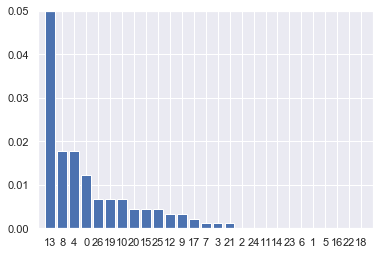

In [69]:
from mlxtend.evaluate import feature_importance_permutation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size=.20, random_state=42, 
                                                    stratify=y.values)

scorecard.fit(X_train, y_train)
imp_vals, _ = feature_importance_permutation(
    predict_method=scorecard.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=1,
    seed=1)

print(imp_vals)

indices = np.argsort(imp_vals)[::-1]
plt.figure()
plt.bar(range(X.shape[1]), imp_vals[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.05])
plt.show()

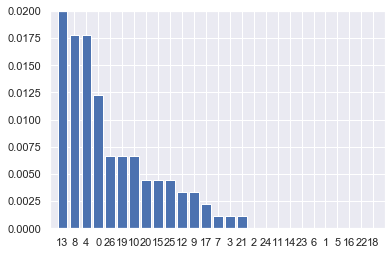

In [70]:
indices = np.argsort(imp_vals)[::-1]
plt.figure()
plt.bar(range(X.shape[1]), imp_vals[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.02])
plt.show()

In [73]:
df[df['Arrest Flag']== 'Y'].groupby('Subject Age Group').count()

,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Beat,subject_age_groups,stop_resolution,arrest_flag,weapon_present,officer_gender,officer_race,subject_race,subject_gender,hour
Subject Age Group,,,,,,,,,,,,,,,,,,,,,
-,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
1 - 17,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
18 - 25,193,193,193,193,193,193,193,193,193,193,...,193,193,193,193,193,193,193,193,193,193
26 - 35,467,467,467,467,467,467,467,467,467,467,...,467,467,467,467,467,467,467,467,467,467
36 - 45,336,336,336,336,336,336,336,336,336,336,...,336,336,336,336,336,336,336,336,336,336
46 - 55,170,170,170,170,170,170,170,170,170,170,...,170,170,170,170,170,170,170,170,170,170
56 and Above,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree._tree import TREE_LEAF

In [16]:
def plot_tree(dt, used_cols, out_file='mytree.dot'):
    export_graphviz(dt, out_file=out_file, 
                    filled=True, feature_names=used_cols, 
                    leaves_parallel=True, node_ids=True, rotate=True)
    with open(out_file) as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)
    

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

In [38]:
# used_cols = [c for c in df.columns if c not in excluded_cols]
used_cols = ['Final Call Type',
             'Subject Perceived Race',
#              'Officer ID',
             'hour',
             'Beat']

X = df[used_cols]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size=.20, random_state=42, 
                                                    stratify=y.values)

dt = DecisionTreeClassifier(criterion='entropy',
                            max_depth=3,
                            min_samples_leaf=5,
                            random_state=42,
                            class_weight='balanced')

encoder = WOEEncoder()
scorecard = make_pipeline(objectify, encoder, dt)

scores = cross_val_score(scorecard, X, y, cv=5, scoring='accuracy')
print(scores.mean(), "+/-", scores.std())

0.7523477168388565 +/- 0.023121649059105936


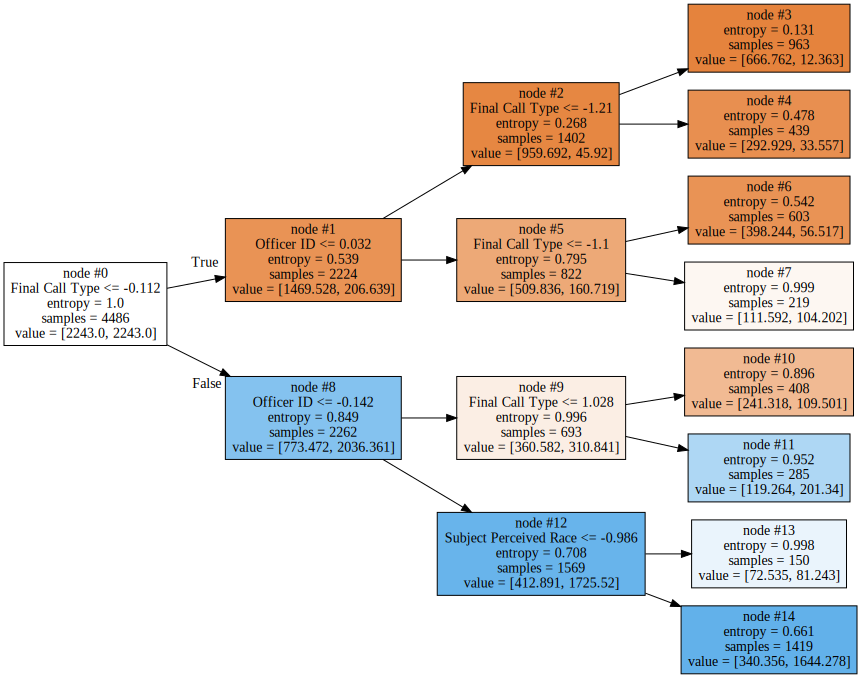

In [18]:
X_transformed = Pipeline(scorecard.steps[:-1]).fit_transform(X, y)
dt.fit(X_transformed, y)
plot_tree(dt, used_cols)

In [19]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree_logic(data):")
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if data['{}'] <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if data['{}'] > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1)

In [20]:
tree_to_code(dt, used_cols)

def tree_logic(data):
  if data['Final Call Type'] <= -0.111551184207201:
    if data['Officer ID'] <= 0.03228984959423542:
      if data['Final Call Type'] <= -1.2101634740829468:
        return [[666.76243781  12.36299213]]
      else:  # if data['Final Call Type'] > -1.2101634740829468
        return [[292.92910448  33.55669291]]
    else:  # if data['Officer ID'] > 0.03228984959423542
      if data['Final Call Type'] <= -1.100422739982605:
        return [[398.24409204  56.51653543]]
      else:  # if data['Final Call Type'] > -1.100422739982605
        return [[111.5920398 104.2023622]]
  else:  # if data['Final Call Type'] > -0.111551184207201
    if data['Officer ID'] <= -0.14186349511146545:
      if data['Final Call Type'] <= 1.0279635190963745:
        return [[241.31778607 109.5007874 ]]
      else:  # if data['Final Call Type'] > 1.0279635190963745
        return [[119.26399254 201.34015748]]
    else:  # if data['Officer ID'] > -0.14186349511146545
      if data['Subject P